In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from matplotlib import dates as mdates
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Load your stock prices data
df = pd.read_csv('D:\CTG.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Convert the data into a graph structure
timestamps = df.index.tolist()
prices = df['Price'].tolist()

In [2]:
# Create edges where each timestamp is connected to the next one
edge_index = torch.tensor([list(range(len(timestamps)-1)), list(range(1, len(timestamps)))], dtype=torch.long)

# Create node features (price at each timestamp)
x = torch.tensor(prices[:-1], dtype=torch.float).view(-1, 1)  # Remove the last element to align with y

# Create a target variable (predict the next day's price)
y = torch.tensor(prices[1:], dtype=torch.float)

# Split the data into training and testing sets (80-20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index, y=y_test)


In [3]:
# Define a simple GNN model
class SimpleGNN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = nn.Linear(num_features, hidden_size)
        self.conv2 = nn.Linear(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)

        return x

# Instantiate the GNN model, loss function, and optimizer
model = SimpleGNN(num_features=1, hidden_size=16, num_classes=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the GNN on the training data
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, train_data.y.view(-1, 1))
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/100, Loss: 521199232.0
Epoch 2/100, Loss: 488199936.0
Epoch 3/100, Loss: 456160864.0
Epoch 4/100, Loss: 425112832.0
Epoch 5/100, Loss: 395080896.0
Epoch 6/100, Loss: 366085408.0
Epoch 7/100, Loss: 338142752.0
Epoch 8/100, Loss: 311265888.0
Epoch 9/100, Loss: 285465088.0
Epoch 10/100, Loss: 260748432.0
Epoch 11/100, Loss: 237122160.0
Epoch 12/100, Loss: 214591888.0
Epoch 13/100, Loss: 193162640.0
Epoch 14/100, Loss: 172839808.0
Epoch 15/100, Loss: 153629456.0
Epoch 16/100, Loss: 135538864.0
Epoch 17/100, Loss: 118576528.0
Epoch 18/100, Loss: 102752152.0
Epoch 19/100, Loss: 88076224.0
Epoch 20/100, Loss: 74559392.0
Epoch 21/100, Loss: 62211376.0
Epoch 22/100, Loss: 51039656.0
Epoch 23/100, Loss: 41047816.0
Epoch 24/100, Loss: 32233598.0
Epoch 25/100, Loss: 24586884.0
Epoch 26/100, Loss: 18087592.0
Epoch 27/100, Loss: 12703579.0
Epoch 28/100, Loss: 8388970.0
Epoch 29/100, Loss: 5082755.5
Epoch 30/100, Loss: 2708235.75
Epoch 31/100, Loss: 1173245.375
Epoch 32/100, Loss: 371491.625


In [4]:
# Evaluate the model on the testing data
model.eval()
with torch.no_grad():
    test_predictions = model(test_data)

# Convert torch tensors to numpy arrays for plotting
x_train_np = x_train.numpy().flatten()
y_train_np = y_train.numpy()

x_test_np = x_test.numpy().flatten()
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.numpy().flatten()


In [5]:
# Extend the time range for future 30 days
future_timestamps = pd.date_range(start=timestamps[-1], periods=30, freq='B')  # Assuming business days
future_prices = []


In [6]:
# Use the trained GNN model to make predictions for the next 30 days
model.eval()
with torch.no_grad():
    for i in range(30):
        # Create node features for the next day's prediction
        future_x = torch.tensor([prices[-1]], dtype=torch.float).view(1, 1)

        # Create a Data object for the future prediction
        future_data = Data(x=future_x, edge_index=edge_index)

        # Make the prediction
        future_prediction = model(future_data).item()

        # Append the predicted price to the list
        future_prices.append(future_prediction)

        # Update prices list for the next iteration
        prices.append(future_prediction)

# Convert torch tensors to numpy arrays for plotting
future_timestamps_np = mdates.date2num(future_timestamps)
future_prices_np = torch.tensor(future_prices, dtype=torch.float).numpy()

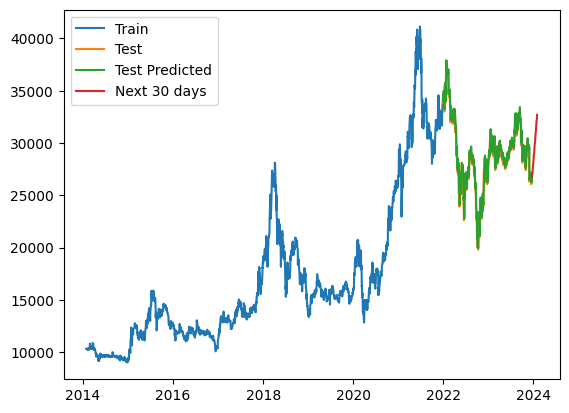

In [7]:
# Plot actual vs predicted prices for both training, test, and future predictions
plt.plot(df.index[:len(y_train_np)], y_train_np, label='Train')
plt.plot(df.index[len(y_train_np): len(y_train_np) + len(y_test_np)], y_test_np, label='Test')
plt.plot(df.index[len(y_train_np): len(y_train_np) + len(test_predictions_np)], test_predictions_np, label='Test Predicted')
plt.plot(mdates.num2date(future_timestamps_np), future_prices_np, label='Next 30 days', )
plt.legend()
plt.show()

In [8]:
# Tính MAE cho testing
mae_test = mean_absolute_error(y_test_np, test_predictions_np)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test_np, test_predictions_np)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test_np, test_predictions_np, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test_np,test_predictions_np, squared=False)

mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('----------------------')


---------TEST----------
MAPE: 1.723
MAE: 478.435
RMSE: 653.52
MSLE: 0.024
----------------------
